In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data download
# kaggle: https://www.kaggle.com/datasets/marklvl/sentiment-labelled-sentences-data-set

!wget -q --show-progress https://raw.githubusercontent.com/rambabar/NLP/main/data/ford_sentence_data.zip

ford_sentence_data. 100%[===================>]   2.92M  --.-KB/s    in 0.07s   


In [ ]:
!mkdir data
!unzip /content/sentiment_labelled_sentences.zip -d /content/data

unzip:  cannot find or open /content/sentiment_labelled_sentences.zip, /content/sentiment_labelled_sentences.zip.zip or /content/sentiment_labelled_sentences.zip.ZIP.


In [ ]:
# # If Training time of model is more to prevent disconnect
# #Just open Chrome DevTools by pressing F12 or Ctrl+Shift+I on Linux & run following JavaScript code in your console:
# '''
# function KeepClicking(){
#    console.log("Clicking");
#    document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(KeepClicking,60000)
# '''

In [ ]:
# #Spark written in Scala programming language & requires Java Virtual Machine (JVM) to run. Therefore, download Java.
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# # install Apache Spark with Hadoop (change the version number if needed) # https://downloads.apache.org/spark/
# # !wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# !wget -q http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
# !tar xf spark-3.3.1-bin-hadoop3.tgz

# # unzip the spark file to the current folder
# # !tar xf spark-3.0.0-bin-hadoop3.2.tgz
# #install findspark library using pip that will locate Spark on the system and import it as a regular library.
# !pip install -q findspark #sparknlp
# # set your spark folder to your system path environment. 
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# # os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
# os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

# import findspark
# findspark.init()
# findspark.find()
# # # OR
# # # # #install pyspark
# # # !pip install -q wheel
# # # !pip install -q pyspark

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
!pip install -q pyspark==3.3.0 spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.7 MB/s eta 0:00:00


In [ ]:
import sparknlp

spark = sparknlp.start()
# params =>> gpu=False

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.3.0


In [ ]:
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars && ls -lt

total 43992
-rw-r--r-- 1 root root 45044627 Nov 28 16:37 spark-nlp_2.12-4.2.4.jar


In [ ]:
#https://github.com/DunnBC22/Spark_Projects/blob/main/Python%20(PySpark)/NLP/Sentiment%20Analysis/Sentiment%20Analysis%20of%20Reviews/Sentiment%20Analysis%20of%20Reviews.ipynb

In [ ]:
# import sparknlp
# spark = sparknlp.start()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ford_sent_classifn").config('spark.ui.port', '4050').getOrCreate()
#spark = SparkSession.builder.master("local").appName("pyspark").config('spark.ui.port', '4050').getOrCreate()
#spark=SparkSession.builder.appName("local[*]").getOrCreate()
sc = spark.sparkContext
print("Apache Spark version: ", spark.version)
spark

Apache Spark version:  3.3.0


In [ ]:
#Import Necessary Libraries
import pandas

import pyspark
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import pyspark.sql.functions as F
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Function to Ingest Data

def ingest_data(file_location: str) -> pandas.DataFrame:
    '''
    This function ingests a single data file at a time.
    '''
    
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "false"
    line_sep = '\n'
    
    dataset = spark.read.text(file_location, lineSep="\n")
    
    dataset = dataset.withColumn("text", F.split(dataset['value'], '\t').getItem(0)) \
                    .withColumn("label", F.split(dataset['value'], '\t').getItem(1)) \
                    .drop("value")
    
    return dataset
    
# Function to Ingest & Concatenate Multiple Files at Once

def ingest_multiple_files(files: [], schema: StructType) -> pandas.DataFrame:
    '''
    This function concatenates multiple data files into one after calling 
    the 'ingest_data' function to ingest them individually.
    '''
    temp_df = spark.createDataFrame([], schema)
    new_df = spark.createDataFrame([], schema)
    
    for x in files:
        # Ingest next dataset
        temp_df = ingest_data(x)
        # Concatenate it to existing dataset
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    
    return new_df

# Function to Evaluate Metrics

def metrics_eval(prediction: pandas.Series, label: pandas.Series, model_name: str) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
        & F1-score, among others)
    - Confusion Matrix
    '''
    
    print("-------------------------------------------------------------")
    print(f"The {model_name} Model:")
    print("-------------------------------------------------------------")
    print(f"Classification Report for the {model_name} Model:")
    
    report = classification_report(label, prediction, zero_division=1)
    print(report)
    
    print("-------------------------------------------------------------")
    
    print(f"Confusion Matrix for the {model_name} Model:")
    cm = confusion_matrix(label, prediction)
    dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()
    
    print("-------------------------------------------------------------")

In [ ]:
#Ingest & Preprocess Dataset

file_1 = "/content/data/amazon_cells_labelled.txt"
file_2 = "/content/data/imdb_labelled.txt"
file_3 = "/content/data/yelp_labelled.txt"

files_to_ingest = [file_1, file_2, file_3]

orig_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
])

df = ingest_multiple_files(files_to_ingest, orig_schema)

df = df.withColumn("text_len", F.size(F.split(F.col('text'), ' ')))

df = df.withColumn("label",\
        F.when(df["label"]=="0", F.regexp_replace(df["label"], "0", "negative"))\
        .when(df["label"]=="1", F.regexp_replace(df["label"], "1", "positive")))

df = df.na.drop(subset=["label"])

display(df)

DataFrame[text: string, label: string, text_len: int]

In [ ]:
#Remove Unnecessary Feature

df = df.drop("text_len")

In [ ]:
## Define Pipeline Stages & Instantiate Pipeline
# Create Pipeline Stages

MODEL_NAME='sentimentdl_use_twitter'

document_assembler = DocumentAssembler() \
    .setInputCol("text")\
    .setOutputCol("doc")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["doc"])\
    .setOutputCol("use")

sent_dl_clf = SentimentDLModel.pretrained(MODEL_NAME, lang='en')\
    .setInputCols(["use"])\
    .setOutputCol("class")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [ ]:
# Create Pipeline

sent_dl_pipe = Pipeline().setStages([document_assembler, use, sent_dl_clf])

In [ ]:
## Evaluate Samples & Evaluate Results
# Train & Create Predictions Using Trained Sentiment Analysis Model

preds = sent_dl_pipe.fit(df).transform(df)
     

In [ ]:
# Return Condensed Predictions in Pandas DataFrame Form

preds_in_pandas = (preds.select(F.col('text').alias("text"), F.col('label').alias("ground_truth"), F.col('class.result').alias("prediction"))).toPandas()

preds_in_pandas['prediction'] = preds_in_pandas['prediction'].apply(lambda x : x[0])

-------------------------------------------------------------
The Sentiment Analysis Model:
-------------------------------------------------------------
Classification Report for the Sentiment Analysis Model:
              precision    recall  f1-score   support

    negative       0.83      0.80      0.81      1500
     neutral       0.00      1.00      0.00         0
    positive       0.83      0.81      0.82      1500

    accuracy                           0.81      3000
   macro avg       0.55      0.87      0.55      3000
weighted avg       0.83      0.81      0.82      3000

-------------------------------------------------------------
Confusion Matrix for the Sentiment Analysis Model:
-------------------------------------------------------------


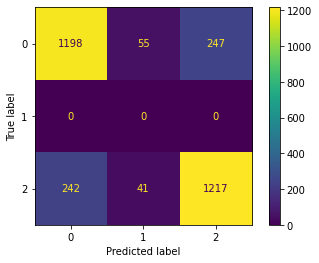

In [ ]:
#Display Metrics via Metrics Function Defined Above

metrics_eval(preds_in_pandas['prediction'], preds_in_pandas['ground_truth'], "Sentiment Analysis")

In [ ]:
from sparknlp.base import LightPipeline
light_pipeline = LightPipeline(sent_dl_pipe.fit(df))

# fullannotations = light_pipeline.fullAnnotate("Good case, Excellent value.")
# print(fullannotations)
annotations = light_pipeline.annotate("Good case, Excellent value.")
annotations

{'doc': ['Good case, Excellent value.'],
 'use': ['Good case, Excellent value.'],
 'class': ['positive']}

In [ ]:
light_pipeline.fullAnnotate("Good case, Excellent value.")

[{'doc': [Annotation(document, 0, 26, Good case, Excellent value., {})],
  'use': [Annotation(sentence_embeddings, 0, 26, Good case, Excellent value., {'sentence': '0', 'token': 'Good case, Excellent value.', 'pieceId': '-1', 'isWordStart': 'true'})],
  'class': [Annotation(category, 0, 26, positive, {'sentence': '0', 'positive': '1.0', 'negative': '0.0'})]}]

In [ ]:
light_pipeline.annotate("Good case, Excellent value.")

{'doc': ['Good case, Excellent value.'],
 'use': ['Good case, Excellent value.'],
 'class': ['positive']}

In [ ]:
#End Spark Session

# spark.stop()

In [ ]:

# GitHub - maobedkova/TopicModelling_PySpark_SparkNLP: Tutorial for Topic Modelling using PySpark and Spark NLP
# https://github.com/maobedkova/TopicModelling_PySpark_SparkNLP

# GitHub - DunnBC22/Spark_Projects: This is the repository for all of my Spark projects, which include Spark NLP & Computer Vision projects.
# https://github.com/DunnBC22/Spark_Projects

# GitHub - prabhupavitra/Text-Summarization-PySpark: Text summarization algorithms using PySpark
# https://github.com/prabhupavitra/Text-Summarization-PySpark

# GitHub - MWFK/NLP-from-Zero-to-Hero: Compilation of NLP notebooks from various sources that address several technical challenges.
# https://github.com/MWFK/NLP-from-Zero-to-Hero

# GitHub - avisionary/reddit-comments-analysis: Big data project to analyze (Subreddit : NoStupidQuestions) comments
# https://github.com/avisionary/reddit-comments-analysis

# GitHub - SolanaO/Healthcare_SparkNLP_Study: SparkNLP and Healthcare SparkNLP based analysis of scientific literature on equine colic.
# https://github.com/SolanaO/Healthcare_SparkNLP_Study

# GitHub - martinKindall/spark_ml_and_nlp: Spark training examples of Machine Learning and Natural Language Processing, using Spark ML and Spark NLP libraries.
# https://github.com/martinKindall/spark_ml_and_nlp

# GitHub - fabiod20/big-data-analytics-and-business-intelligence: Final project of "Big Data Analytics and Business Intelligence" course.
# https://github.com/fabiod20/big-data-analytics-and-business-intelligence

# spark-nlp-Pyspark/spark-nlp.ipynb at master · GhaidaaShtayeh/spark-nlp-Pyspark · GitHub
# https://github.com/GhaidaaShtayeh/spark-nlp-Pyspark/blob/master/spark-nlp.ipynb

# https://github.com/josejuanmartinez/medium/blob/main/mlflow/mlflow.md

# Experiment Tracking
# https://nlp.johnsnowlabs.com/docs/en/mlflow
# Johnsnowlabs
# Spark NLP
# High Performance NLP with Apache Spark
# https://medium.com/spark-nlp/serving-spark-nlp-via-api-spring-and-lightpipelines-64d2e6413327

# ATIS - Intent classification with Spark NLP | Kaggle
# https://www.kaggle.com/code/drscarlat/atis-intent-classification-with-spark-nlp

# Kaggle
# ATIS - Intent classification with Spark NLP
# Explore and run machine learning code with Kaggle Notebooks | Using data from ATIS Airline Travel Information System
# NBME - Spark NLP Healthcare | Kaggle
# https://www.kaggle.com/code/lhd0430/nbme-spark-nlp-healthcare

# Kaggle
# NBME - Spark NLP Healthcare
# Explore and run machine learning code with Kaggle Notebooks | Using data from NBME - Score Clinical Patient Notes
# Spark NLP via PySpark - Recognize Entities | Kaggle
# https://www.kaggle.com/code/almogtavor/spark-nlp-via-pyspark-recognize-entities

# Kaggle
# Spark NLP via PySpark - Recognize Entities
# Explore and run machine learning code with Kaggle Notebooks | Using data from No attached data sources
# Universal Sentence Encoder 74% accuracy sparknlp | Kaggle
# https://www.kaggle.com/code/nikhileswarkomati/universal-sentence-encoder-74-accuracy-sparknlp

# Kaggle
# Universal Sentence Encoder 74% accuracy sparknlp
# Explore and run machine learning code with Kaggle Notebooks | Using data from Suicide and Depression Detection
# https://github.com/JohnSnowLabs/spark-nlp-workshop

# Spark NLP 101: LightPipeline - KDnuggets
# https://www.kdnuggets.com/2019/11/spark-nlp-101-lightpipeline.html

# John Snow Labs - Spark NLP
# https://nlp.johnsnowlabs.com/

# How to Extract Medical Information From Unstructured Data Using NLP
# https://www.topcoder.com/thrive/articles/how-to-extract-medical-information-from-unstructured-data-using-nlp

# https://www.analyticsvidhya.com/blog/2020/07/build-text-categorization-model-with-spark-nlp/

# https://github.com/JohnSnowLabs/spark-nlp-models
# https://heartbeat.comet.ml/new-integration-comet-spark-nlp-276987144d1c

# https://youtu.be/jZAhLmet6Yk


# Some major tasks of NLP are automatic summarization, discourse analysis, machine translation, conference resolution, speech recognition, etc. Automatic summarization helps the computer provide us with a summary for a specific text, article, journals, etc.

# A customer support bot.
# A language identifier.
# An ML-powered autocomplete feature.
# A predictive text generator.
# A media monitor.

# One of the most important and challenging tasks in the entire NLP process is to train a machine to derive the actual meaning of words, especially when the same word can have multiple meanings within a single document.
# high demand nlp tasks

In [ ]:
# https://sparkbyexamples.com/pyspark/pyspark-aggregate-functions/
# https://jaceklaskowski.gitbooks.io/mastering-spark-sql/content/